In [1]:
import numpy as np
import copy
from astropy.io import fits
import matplotlib.pyplot as plt
plt.rcParams['image.origin']='lower'
import os
from pathlib import Path

import proper
proper.use_ffti = False
proper.use_fftw = False

import roman_phasec_proper as phasec
phasec.copy_here()
import falco
print(proper.__version__, phasec.__version__)

from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider

falco_dir = Path(os.path.dirname(falco.__file__))
roman_dir = Path(os.path.dirname(falco_dir))/'roman'
print(falco_dir)
print(roman_dir)

import misc_funs as misc

3.2.7 1.4


/home/kianmilani/Projects/falco-python/falco
/home/kianmilani/Projects/falco-python/roman


# Setup the model parameters for a monochromatic HLC run

In [2]:
mp = falco.config.ModelParameters()
mp.compact = falco.config.Object()
mp.full = falco.config.Object()
mp.centering = 'pixel'

# Path to data needed by PROPER model
mp.full.data_dir = phasec.data_dir
LOCAL_PATH = os.getcwd()
flatmap_path = os.path.join(LOCAL_PATH, 'flatmaps')

mp.flagParallel = True
mp.flagPlot = True

# parameters for evaluating system throughput
mp.thput_metric = 'HMI'
mp.thput_radius = 0.7  # photometric aperture radius [lambda_c/D]. Used ONLY for 'EE' method.
mp.thput_eval_x = -7  # x location [lambda_c/D] in dark hole at which to evaluate throughput
mp.thput_eval_y = 0  # y location [lambda_c/D] in dark hole at which to evaluate throughput

# Where to shift the source to compute the intensity normalization value.
mp.source_x_offset_norm = -7  # x location [lambda_c/D] in dark hole at which to compute intensity normalization
mp.source_y_offset_norm = 0  # y location [lambda_c/D] in dark hole at which to compute intensity normalization

# Choose E-field estimator
mp.estimator = 'perfect' # uses exact computed E-field
# mp.estimator = 'pwp-bp' # uses PWP to estimate E-field
mp.est = falco.config.Object()
mp.est.probe = falco.config.Probe()
mp.est.probe.Npairs = 3  # Number of pair-wise probe PAIRS to use.
mp.est.probe.whichDM = 1  # Which DM # to use for probing. 1 or 2. Default is 1
mp.est.probe.radius = 12  # Max x/y extent of probed region [actuators].
mp.est.probe.xOffset = 0  # offset of probe center in x [actuators]. Use to avoid central obscurations.
mp.est.probe.yOffset = 14  # offset of probe center in y [actuators]. Use to avoid central obscurations.
mp.est.probe.axis = 'alternate'  # which axis to have the phase discontinuity along [x or y or xy/alt/alternate]
mp.est.probe.gainFudge = 1

mp.ctrl = falco.config.Object()
mp.ctrl.flagUseModel = True  # Whether to perform a model-based (vs empirical) grid search for the controller
# Grid- or Line-Search Settings
mp.ctrl.log10regVec = np.arange(-6, -2, 1/2)  # log10 of the regularization exponents (often called Beta values)
mp.ctrl.dmfacVec = np.array([0.5])  # Proportional gain term applied to the total DM delta command. Usually in range [0.5,1]. [1-D ndarray]

# Threshold for culling weak actuators from the Jacobian:
mp.logGmin = -6  # 10^(mp.logGmin) used on the intensity of DM1 and DM2 Jacobians to weed out the weakest actuators

# Zernikes to suppress with controller
mp.jac = falco.config.Object()
mp.jac.zerns = np.array([1])  # Which Zernike modes to include in Jacobian. Given as the max Noll index. Always include the value "1" for the on-axis piston mode.
mp.jac.Zcoef = 1e-9*np.ones(np.size(mp.jac.zerns))  # meters RMS of Zernike aberrations. (piston value is reset to 1 later)
mp.jac.minimizeNI = True  # Have EFC minimize normalized intensity instead of intensity

# Zernikes to compute sensitivities for
mp.eval = falco.config.Object()
mp.eval.indsZnoll = np.array([])  # Noll indices of Zernikes to compute values for

# Annuli to compute 1nm RMS Zernike sensitivities over. Columns are [inner radius, outer radius]. One row per annulus.
mp.eval.Rsens = np.array([])  # np.array([[3., 4.], [4., 5.], [5., 8.], [8., 9.]]);  # [2-D ndarray]

# Spatial pixel weighting
mp.WspatialDef = []  # [3, 4.5, 3]; # spatial control Jacobian weighting by annulus: [Inner radius, outer radius, intensity weight; (as many rows as desired)]

mp.dm1.weight = 1
mp.dm2.weight = 1

mp.controller = 'gridsearchEFC'

# # GRID SEARCH EFC DEFAULTS
# WFSC Iterations and Control Matrix Relinearization
mp.Nitr = 10  # Number of estimation+control iterations to perform
mp.relinItrVec = np.arange(0, mp.Nitr)  # Which correction iterations at which to re-compute the control Jacobian [1-D ndarray]
mp.dm_ind = np.array([1, 2]) # Which DMs to use [1-D ndarray]


mp.dm1.inf_fn = falco.INFLUENCE_XINETICS
mp.dm2.inf_fn = falco.INFLUENCE_XINETICS

mp.dm1.dm_spacing = 0.9906e-3  # User defined actuator pitch
mp.dm2.dm_spacing = 0.9906e-3  # User defined actuator pitch

mp.dm1.inf_sign = '+'
mp.dm2.inf_sign = '+'

# %% Deformable Mirrors: Optical Layout Parameters

# DM1 parameters
mp.dm1.orientation = 'rot180'  # Change to mp.dm1.V orientation before generating DM surface. Options: rot0, rot90, rot180, rot270, flipxrot0, flipxrot90, flipxrot180, flipxrot270
mp.dm1.Nact = 48  # of actuators across DM array
mp.dm1.VtoH = 1e-9*np.ones((48, 48))  # gains of all actuators [nm/V of free stroke]
mp.dm1.xtilt = 0  # for foreshortening. angle of rotation about x-axis [degrees]
mp.dm1.ytilt = 9.65  # for foreshortening. angle of rotation about y-axis [degrees]
mp.dm1.zrot = 0  # clocking of DM surface [degrees]
mp.dm1.xc = (48/2 - 1/2)  # x-center location of DM surface [actuator widths]
mp.dm1.yc = (48/2 - 1/2)  # y-center location of DM surface [actuator widths]
mp.dm1.edgeBuffer = 1  # max radius (in actuator spacings) outside of beam on DM surface to compute influence functions for. [actuator widths]

# DM2 parameters
mp.dm2.orientation = 'rot180'  # Change to mp.dm1.V orientation before generating DM surface. Options: rot0, rot90, rot180, rot270, flipxrot0, flipxrot90, flipxrot180, flipxrot270
mp.dm2.Nact = 48  # of actuators across DM array
mp.dm2.VtoH = 1e-9*np.ones((48, 48))  # gains of all actuators [nm/V of free stroke]
mp.dm2.xtilt = 0  # for foreshortening. angle of rotation about x-axis [degrees]
mp.dm2.ytilt = 9.65  # for foreshortening. angle of rotation about y-axis [degrees]
mp.dm2.zrot = 0  # clocking of DM surface [degrees]
mp.dm2.xc = (48/2 - 1/2)  # x-center location of DM surface [actuator widths]
mp.dm2.yc = (48/2 - 1/2)  # y-center location of DM surface [actuator widths]
mp.dm2.edgeBuffer = 1  # max radius (in actuator spacings) outside of beam on DM surface to compute influence functions for. [actuator widths]


#  Aperture stops at DMs
mp.flagDM1stop = False   # Whether to apply an iris or not
mp.dm1.Dstop = 100e-3  # Diameter of iris [meters]
mp.flagDM2stop = True  # Whether to apply an iris or not
mp.dm2.Dstop = 51.5596e-3  # Diameter of iris [meters]

# DM separations
mp.d_P2_dm1 = 0  # distance (along +z axis) from P2 pupil to DM1 [meters]
mp.d_dm1_dm2 = 1.000  # distance between DM1 and DM2 [meters]


/home/kianmilani/Projects/falco-python/falco/config


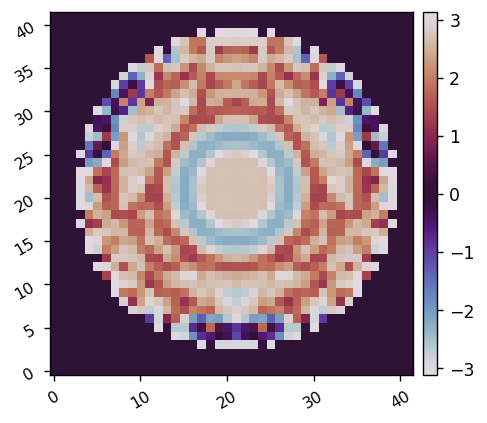

In [3]:
mp.lambda0 = 575e-9  # Central wavelength of the whole spectral bandpass [meters]
mp.fracBW = 0.010  # fractional bandwidth of the whole bandpass (Delta lambda / lambda0)
mp.Nsbp = 1  # Number of sub-bandpasses to divide the whole bandpass into for estimation and control
mp.Nwpsbp = 1  # Number of wavelengths to used to approximate an image in each sub-bandpass

# Key Optical Layout Choices
mp.flagSim = True  # Simulation or not
mp.layout = 'roman_phasec_proper'  # Which optical layout to use
mp.coro = 'HLC'
mp.flagRotation = False  # Whether to rotate 180 degrees between conjugate planes in the compact model
mp.flagApod = False  # Whether to use an apodizer or not
mp.flagDMwfe = False  # Whether to use BMC DM quilting maps

mp.Fend = falco.config.Object()

# Final Focal Plane Properties
mp.Fend.res = mp.lambda0/(500e-9)*2  # Sampling [ pixels per lambda0/D]
mp.Fend.FOV = 12.0  # half-width of the field of view in both dimensions [lambda0/D]

# Correction and scoring region definition
mp.Fend.corr = falco.config.Object()
mp.Fend.corr.Rin = 2.8  # inner radius of dark hole correction region [lambda0/D]
mp.Fend.corr.Rout = 9.7  # outer radius of dark hole correction region [lambda0/D]
mp.Fend.corr.ang = 180  # angular opening of dark hole correction region [degrees]

mp.Fend.score = falco.config.Object()
mp.Fend.score.Rin = 3.0  # inner radius of dark hole scoring region [lambda0/D]
mp.Fend.score.Rout = 9.0  # outer radius of dark hole scoring region [lambda0/D]
mp.Fend.score.ang = 180  # angular opening of dark hole scoring region [degrees]

mp.Fend.sides = 'lr'  # Which side(s) for correction: 'left', 'right', 'top', 'up', 'bottom', 'down', 'lr', 'rl', 'leftright', 'rightleft', 'tb', 'bt', 'ud', 'du', 'topbottom', 'bottomtop', 'updown', 'downup'
mp.Fend.clockAngDeg = 0  # Amount to rotate the dark hole location


# %% Optical Layout: Full PROPER Model

mp.full.cor_type = 'hlc_band1'
mp.full.flagPROPER = True  # Whether the full model is a PROPER prescription

# Pupil Plane Resolutions
mp.P1.full.Nbeam = 309
mp.P1.full.Narr = 310

mp.full.field_stop_radius_lam0 = 9.7  # [lambda0/D]

# Image size and resolutino
mp.full.output_dim = falco.util.ceil_even(1 + mp.Fend.res*(2*mp.Fend.FOV))  # dimensions of output in pixels (overrides output_dim0)
mp.full.final_sampling_lam0 = 1/mp.Fend.res  # final sampling in lambda0/D

# Aberrations and polarization
# mp.full.pol_conds = [-2, -1, 1, 2]  # Which polarization states to use when creating an image.
mp.full.pol_conds = [10, ]
mp.full.polaxis = 10  # Pol state to use when making a single call to the Roman CGI PROPER model  
mp.full.use_errors = True

# DM starting voltages (in the PROPER model only)
fn_dm1_design = os.path.join(flatmap_path, 'dm1_m_design_hlc_band1.fits')
fn_dm2_design = os.path.join(flatmap_path, 'dm2_m_design_hlc_band1.fits')
fn_dm1_flatmap = os.path.join(flatmap_path, 'dm1_m_flat_hlc_band1.fits')
fn_dm2_flatmap = os.path.join(flatmap_path, 'dm2_m_flat_hlc_band1.fits')
mp.full.dm1 = falco.config.Object()
mp.full.dm2 = falco.config.Object()
mp.full.dm1.flatmap = fits.getdata(fn_dm1_flatmap) + fits.getdata(fn_dm1_design)
mp.full.dm2.flatmap = fits.getdata(fn_dm2_flatmap) + fits.getdata(fn_dm2_design)

mp.dm1.biasMap = 50 + mp.full.dm1.flatmap/mp.dm1.VtoH  # Bias voltage. Needed prior to WFSC to allow + and - voltages. Total voltage is mp.dm1.biasMap + mp.dm1.V
mp.dm2.biasMap = 50 + mp.full.dm2.flatmap/mp.dm2.VtoH  # Bias voltage. Needed prior to WFSC to allow + and - voltages. Total voltage is mp.dm2.biasMap + mp.dm2.V


# %% Optical Layout: Compact Model (and Jacobian Model)

# Focal Lengths
mp.fl = 1.0  # [meters] Focal length value used for all FTs in the compact model. Don't need different values since this is a Fourier model.

# Pupil Plane Diameters
mp.P2.D = 46.3e-3
mp.P3.D = 46.3e-3
mp.P4.D = 46.3e-3

# Pupil Plane Resolutions
mp.P1.compact.Nbeam = 300
# mp.P2.compact.Nbeam = 300
mp.P3.compact.Nbeam = 300
mp.P4.compact.Nbeam = 300

# Number of re-imaging relays between pupil planesin compact model. Needed
# to keep track of 180-degree rotations and (1/1j)^2 factors compared to the
# full model, which probably has extra collimated beams compared to the
# compact model.
# NOTE: All these relays are ignored if mp.flagRotation == False
mp.Nrelay1to2 = 1
mp.Nrelay2to3 = 1
mp.Nrelay3to4 = 1
mp.NrelayFend = 1  # How many times to rotate the final image by 180 degrees


# %% Mask Definitions

# Pupil definition
mp.P1.IDnorm = 0.303  # ID of the central obscuration [diameter]. Used only for computing the RMS DM surface from the ID to the OD of the pupil. OD is assumed to be 1.
mp.P1.D = 2.3631  # telescope diameter [meters]. Used only for converting milliarcseconds to lambda0/D or vice-versa.
mp.P1.Dfac = 1  # Factor scaling inscribed OD to circumscribed OD for the telescope pupil.
changes = {'flagRot180': True}
mp.P1.compact.mask = falco.mask.falco_gen_pupil_Roman_CGI_20200513(mp.P1.compact.Nbeam, mp.centering, changes)

# Lyot stop shape
mp.P4.IDnorm = 0.50  # Lyot stop ID [Dtelescope]
mp.P4.ODnorm = 0.80  # Lyot stop OD [Dtelescope]
# wStrut = 3.2/100  # Lyot stop strut width [pupil diameters]
# rocLS = 0.02  # fillet radii [fraction of pupil diameter]
# upsampleFactor = 100  # Lyot and FPM anti-aliasing value
fnLS = os.path.join(mp.full.data_dir, 'hlc_20190210b', 'lyot.fits')
LS0 = fits.getdata(fnLS)
LS0 = falco.util.pad_crop(LS0, 311)
LS1 = falco.mask.rotate_shift_downsample_pupil_mask(
    LS0, 309, mp.P4.compact.Nbeam, 0, 0, 0)
mp.P4.compact.mask = falco.util.pad_crop(LS1, falco.util.ceil_even(np.max(LS1.shape)))
# plt.figure(22); plt.imshow(LS1); plt.colorbar(); plt.magma(); plt.gca().invert_yaxis();  plt.pause(0.5)

# Pinhole used during back-end calibration
mp.F3.pinhole_diam_m = 0.5*32.22*575e-9

# Load the HLC FPM
if mp.Nsbp == 1:
    lambdaFacs = np.array([1, ])
elif mp.Nwpsbp == 1:
    lambdaFacs = np.linspace(1-mp.fracBW/2, 1+mp.fracBW/2, mp.Nsbp)
else:
    DeltaBW = mp.fracBW/(mp.Nsbp)*(mp.Nsbp-1)/2
    lambdaFacs = np.linspace(1-DeltaBW, 1+DeltaBW, mp.Nsbp)

lamUmVec = 1e6*lambdaFacs*mp.lambda0
mp.F3.compact.Nxi = 42  # Crop down to minimum size of the spot
mp.F3.compact.Neta = mp.F3.compact.Nxi
mp.compact.fpmCube = np.zeros((mp.F3.compact.Nxi, mp.F3.compact.Nxi, mp.Nsbp), dtype=complex)
for si in range(mp.Nsbp):
    lambda_um = 1e6*mp.lambda0*lambdaFacs[si]
    fn_p_r = os.path.join(mp.full.data_dir, ('hlc_20190210b/hlc_jacobian_fpm_trans_%.8fum_real.fits' % lamUmVec[si]))
    fn_p_i = os.path.join(mp.full.data_dir, ('hlc_20190210b/hlc_jacobian_fpm_trans_%.8fum_imag.fits' % lamUmVec[si]))
    fpm = fits.getdata(fn_p_r) + 1j*fits.getdata(fn_p_i)
    mp.compact.fpmCube[:, :, si] = falco.util.pad_crop(fpm, mp.F3.compact.Nxi)

mp.F3.compact.res = 2048/309  # sampling of FPM for compact model [pixels per lambda0/D]. DO NOT CHANGE--tied to files.

misc.imshow1(np.angle(mp.compact.fpmCube[:, :, si]), cmap='twilight')


# Run an idealized phase retrieval for the compact model

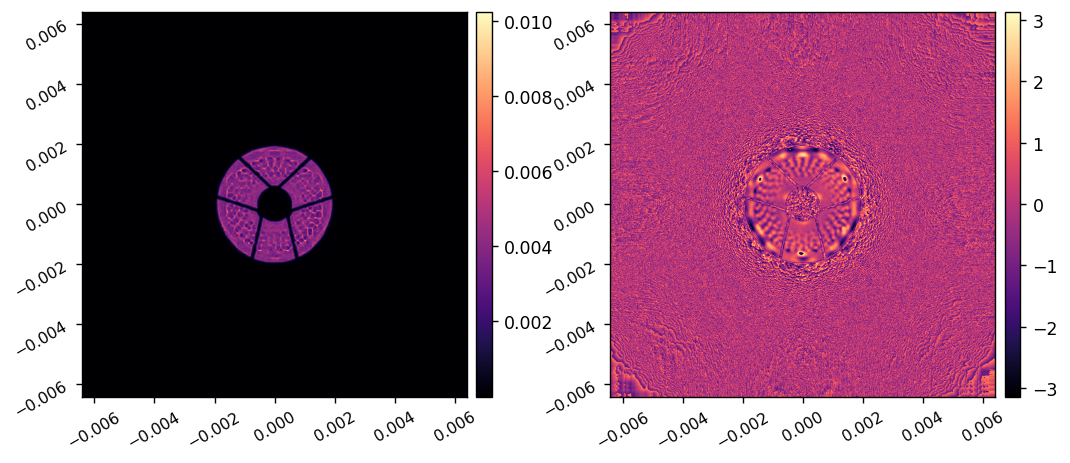

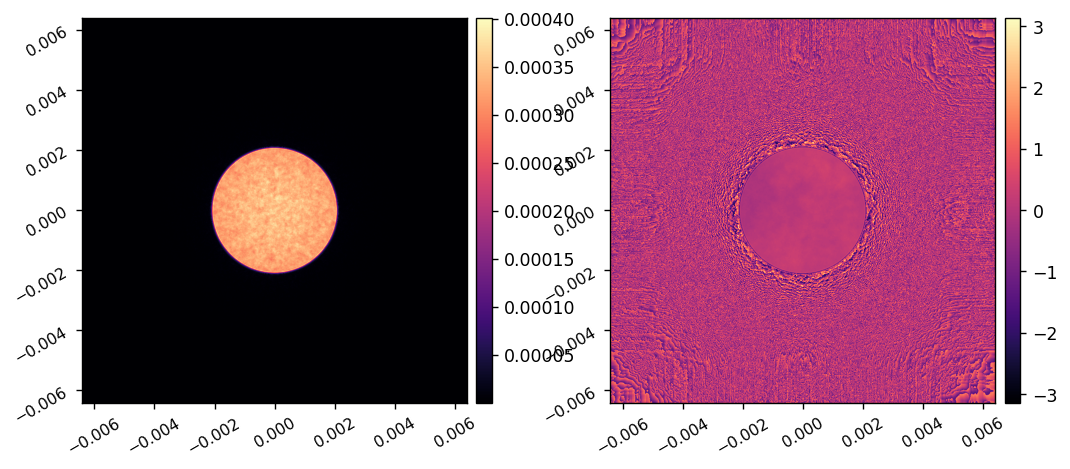

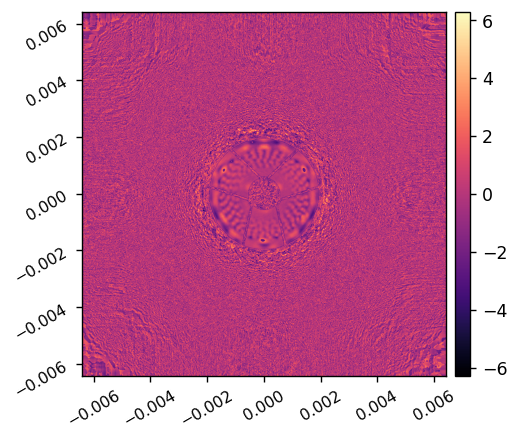

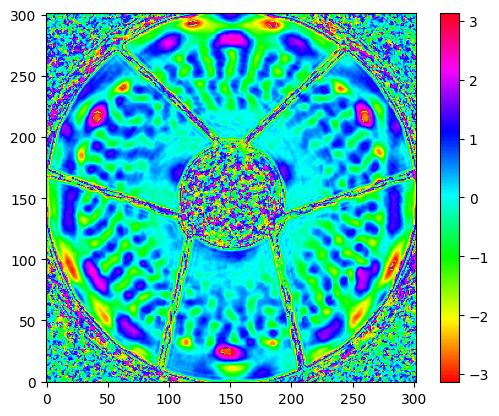

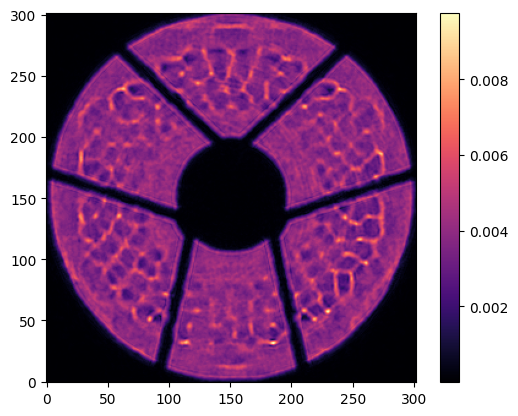

In [4]:

# %% Perform an idealized phase retrieval (get the E-field directly)

optval = copy.copy(mp.full)
optval.source_x_offset = 0
optval.use_dm1 = True
optval.use_dm2 = True
nout = 1024
optval.output_dim = 1024
optval.use_fpm = False
optval.use_pupil_mask = False  # No SPM for getting initial phase
optval.use_lyot_stop = False
optval.use_field_stop = False
optval.use_pupil_lens = True
delattr(optval, 'final_sampling_lam0')

# Use non-SPC flat maps for SPC since SPM has separate aberrations
# downstream that can't be fully captured at entrance pupil with the SPM in
# place. The SPM aberrations are flattened in a separate step not included
# here.
if 'sp' in mp.coro.lower():
    optval.dm1_m = mp.full.dm1.flatmapNoSPM
    optval.dm2_m = mp.full.dm2.flatmapNoSPM
else:
    optval.dm1_m = mp.full.dm1.flatmap
    optval.dm2_m = mp.full.dm2.flatmap

if mp.Nsbp == 1:
    lambdaFacs = np.array([1.])
else:
    lambdaFacs = np.linspace(1-mp.fracBW/2, 1+mp.fracBW/2, mp.Nsbp)

# Get the Input Pupil's E-field
nCompact = falco.util.ceil_even(mp.P1.compact.Nbeam + 1)
mp.P1.compact.E = np.ones((nCompact, nCompact, mp.Nsbp), dtype=complex)
for iSubband in range(mp.Nsbp):

    lambda_um = 1e6*mp.lambda0*lambdaFacs[iSubband]

    # Get aberrations for the full optical train
    optval.pinhole_diam_m = 0  # 0 means don't use the pinhole at FPAM
    fieldFullAll, sampling = proper.prop_run('roman_phasec', lambda_um, nout, QUIET=True, PASSVALUE=optval.__dict__)
    misc.imshow2(np.abs(fieldFullAll), np.angle(fieldFullAll), pxscl=sampling)
    
    # Put pinhole at FPM to get back-end optical aberrations
    optval.pinhole_diam_m = mp.F3.pinhole_diam_m;
    fieldFullBackEnd, sampling = proper.prop_run('roman_phasec', lambda_um, nout, QUIET=True, PASSVALUE=optval.__dict__)
    optval.pinhole_diam_m = 0  # 0 means don't use the pinhole at FPAM
    misc.imshow2(np.abs(fieldFullBackEnd), np.angle(fieldFullBackEnd), pxscl=sampling)
    
    # Subtract off back-end phase aberrations from the phase retrieval estimate
    phFrontEnd = np.angle(fieldFullAll) - np.angle(fieldFullBackEnd)
    misc.imshow1(phFrontEnd, pxscl=sampling)
    
    # Put front-end E-field into compact model
    fieldFull = np.abs(fieldFullAll) * np.exp(1j*phFrontEnd)
    fieldCompactReal = falco.mask.rotate_shift_downsample_pupil_mask(np.real(fieldFull), mp.P1.full.Nbeam, mp.P1.compact.Nbeam, 0, 0, 0)
    fieldCompactImag = falco.mask.rotate_shift_downsample_pupil_mask(np.imag(fieldFull), mp.P1.full.Nbeam, mp.P1.compact.Nbeam, 0, 0, 0)
    fieldCompact = fieldCompactReal + 1j*fieldCompactImag
    fieldCompact = falco.util.pad_crop(fieldCompact, (nCompact, nCompact))
    mp.P1.compact.E[:, :, iSubband] = falco.prop.relay(fieldCompact, 1, centering=mp.centering)

    if mp.flagPlot:
        plt.figure(11); plt.imshow(np.angle(fieldCompact)); plt.colorbar(); plt.hsv(); plt.pause(1e-2)
        plt.figure(12); plt.imshow(np.abs(fieldCompact)); plt.colorbar(); plt.magma(); plt.pause(0.5)

# Don't double count the pupil amplitude with the phase retrieval and a model-based mask
mp.P1.compact.mask = np.ones_like(mp.P1.compact.mask)

hlc_575_test
 Using 1 discrete wavelength(s) in each of 1 sub-bandpasses over a 1.0% total bandpass 

Sub-bandpasses are centered at wavelengths [nm]:	 [575.]


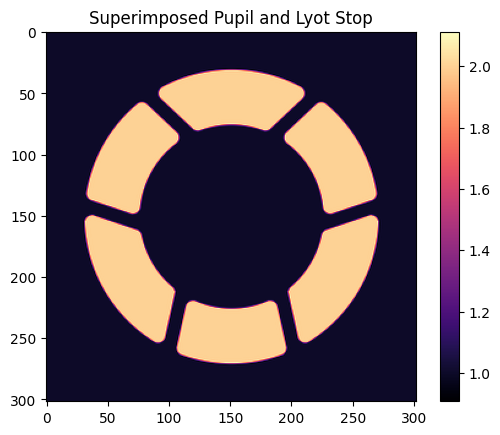

  Influence function padded from 84 to 84 points for A.S. propagation.
Computing datacube of DM influence functions... done.
  Influence function padded from 84 to 84 points for A.S. propagation.
Computing datacube of DM influence functions... done.


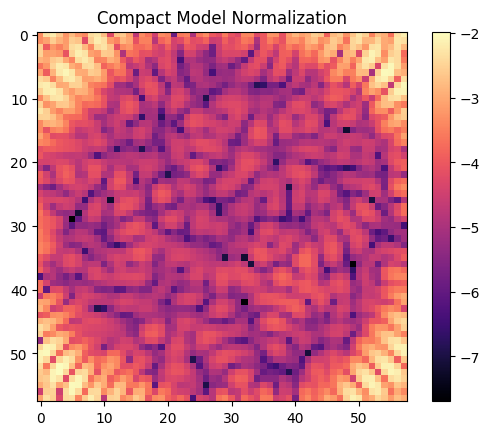

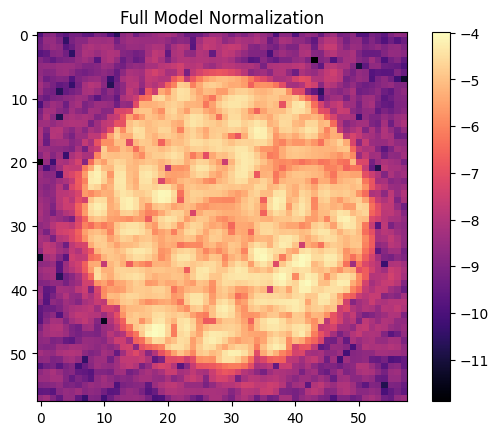


Beginning Trial 1 of Series 1.

DM 1-to-2 Fresnel number (using radius) = 932.0391304347827
Iteration: 0 / 9
Zernike modes (Noll indexing) used in this Jacobian:	[1]
DMs to be used in this iteration = [ 1 2 ]


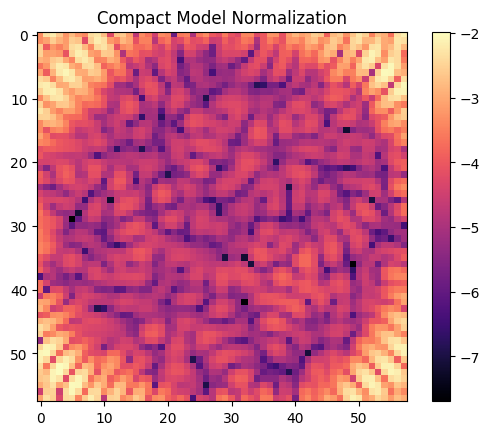

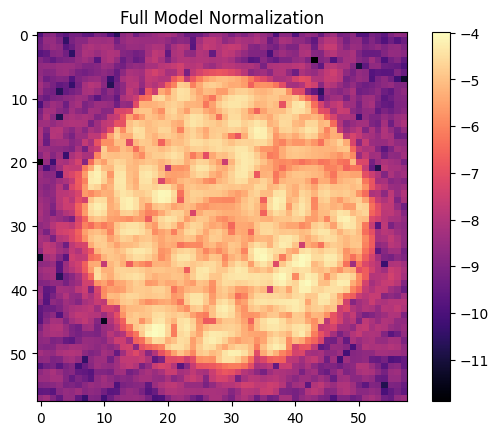

Core throughput within the half-max isophote(s) = 4.59% 	at separation = (-7.0, 0.0) lambda0/D.
Computing control Jacobian matrices in parallel...done.
Elapsed: 54.03594493865967
Weeding out weak actuators from the control Jacobian...
  DM1: 1755/2304 (76.17%) actuators kept for Jacobian
  DM2: 1789/2304 (77.65%) actuators kept for Jacobian
[Getting updated summed image]	Elapsed: 15.01422667503357


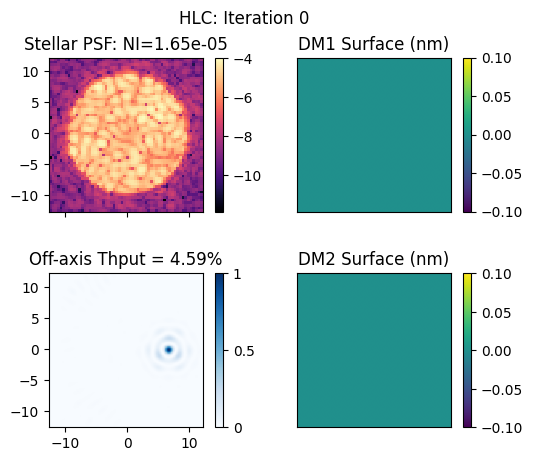

Using the Jacobian to make other matrices...done.
Control beginning ...
Scaling factor:		0.50		0.50		0.50		0.50		0.50		0.50		0.50		0.50		
log10reg:    		-6.0		-5.5		-5.0		-4.5		-4.0		-3.5		-3.0		-2.5		
Inorm:       		1.83e-05	9.20e-06	6.26e-06	5.27e-06	5.06e-06	4.96e-06	4.95e-06	4.96e-06	
Model-based grid search expects log10reg, = -3.0,	 dmfac = 0.50,	 4.95e-06 normalized intensity.
 DM1 P-V in volts: 6.188
 DM2 P-V in volts: 7.915
RMS surface of DM1 = 0.6 nm
RMS surface of DM2 = 0.6 nm
Previous Measured NI:			 1.65e-05 
Saving data snippet to:
	/home/kianmilani/Projects/falco-python/data/brief/hlc_575_test_snippet.pkl  ...done.

Iteration: 1 / 9
Zernike modes (Noll indexing) used in this Jacobian:	[1]
DMs to be used in this iteration = [ 1 2 ]


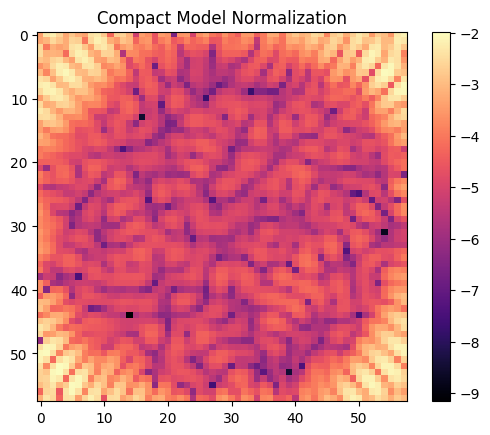

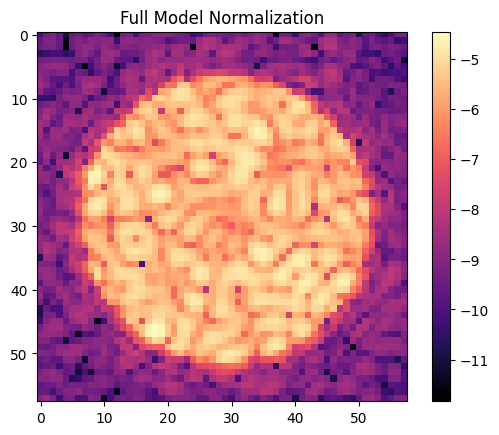

Core throughput within the half-max isophote(s) = 4.60% 	at separation = (-7.0, 0.0) lambda0/D.
Computing control Jacobian matrices in parallel...done.
Elapsed: 45.59381604194641
[Getting updated summed image]	Elapsed: 15.157841205596924


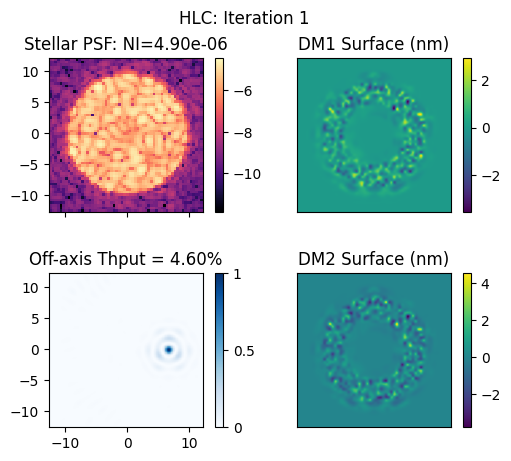

Complex projection of deltaE is 1.07    for subband 0/0
Complex correlation of deltaE is 0.97    for subband 0/0
Using the Jacobian to make other matrices...done.
Control beginning ...
Scaling factor:		0.50		0.50		0.50		0.50		0.50		0.50		0.50		0.50		
log10reg:    		-6.0		-5.5		-5.0		-4.5		-4.0		-3.5		-3.0		-2.5		
Inorm:       		6.44e-06	3.43e-06	2.40e-06	2.02e-06	1.89e-06	1.84e-06	1.81e-06	1.79e-06	
Model-based grid search expects log10reg, = -2.5,	 dmfac = 0.50,	 1.79e-06 normalized intensity.
 DM1 P-V in volts: 8.825
 DM2 P-V in volts: 10.399
RMS surface of DM1 = 0.8 nm
RMS surface of DM2 = 0.9 nm
Previous Measured NI:			 4.90e-06 
Saving data snippet to:
	/home/kianmilani/Projects/falco-python/data/brief/hlc_575_test_snippet.pkl  ...done.

Iteration: 2 / 9
Zernike modes (Noll indexing) used in this Jacobian:	[1]
DMs to be used in this iteration = [ 1 2 ]


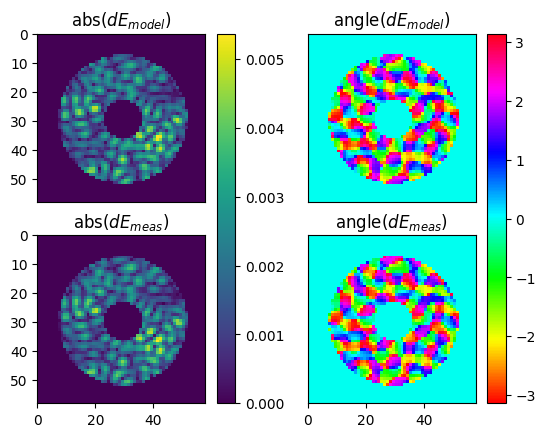

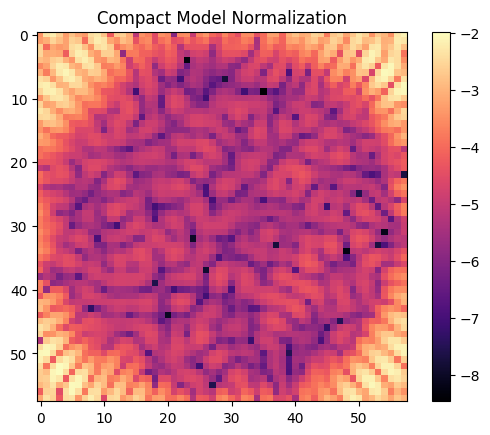

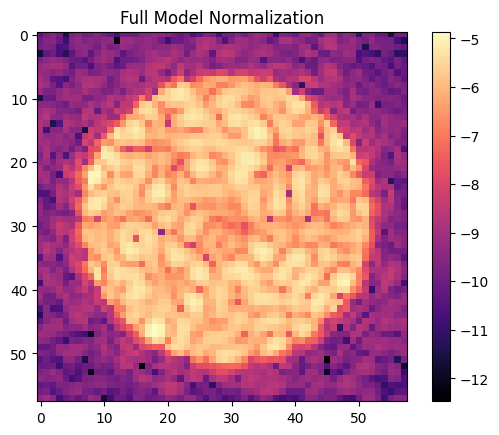

Core throughput within the half-max isophote(s) = 4.60% 	at separation = (-7.0, 0.0) lambda0/D.
Computing control Jacobian matrices in parallel...done.
Elapsed: 46.87407875061035
[Getting updated summed image]	Elapsed: 16.015063047409058


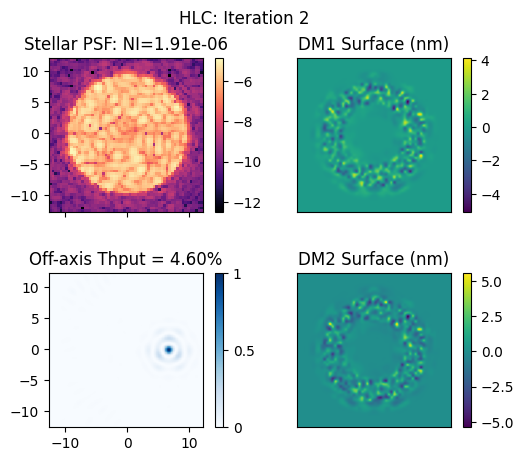

Complex projection of deltaE is 1.15    for subband 0/0
Complex correlation of deltaE is 0.97    for subband 0/0
Using the Jacobian to make other matrices...done.
Control beginning ...
Scaling factor:		0.50		0.50		0.50		0.50		0.50		0.50		0.50		0.50		
log10reg:    		-6.0		-5.5		-5.0		-4.5		-4.0		-3.5		-3.0		-2.5		
Inorm:       		2.60e-06	1.70e-06	1.21e-06	1.00e-06	9.20e-07	8.80e-07	8.58e-07	8.39e-07	
Model-based grid search expects log10reg, = -2.5,	 dmfac = 0.50,	 8.39e-07 normalized intensity.
 DM1 P-V in volts: 10.328
 DM2 P-V in volts: 12.040
RMS surface of DM1 = 0.9 nm
RMS surface of DM2 = 1.0 nm
Previous Measured NI:			 1.91e-06 
Saving data snippet to:
	/home/kianmilani/Projects/falco-python/data/brief/hlc_575_test_snippet.pkl  ...done.

Iteration: 3 / 9
Zernike modes (Noll indexing) used in this Jacobian:	[1]
DMs to be used in this iteration = [ 1 2 ]


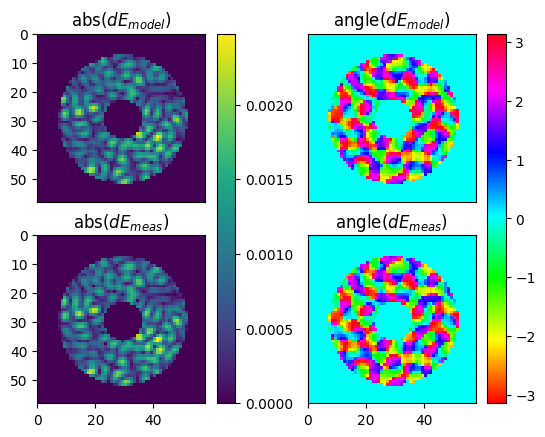

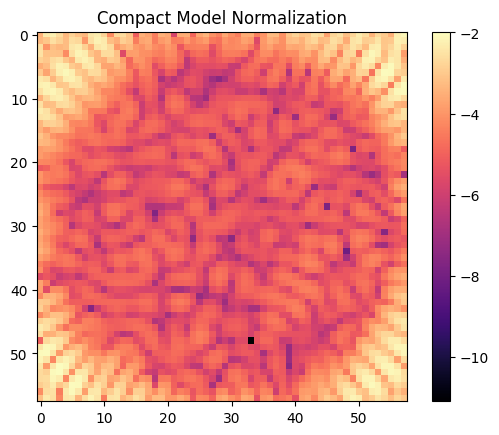

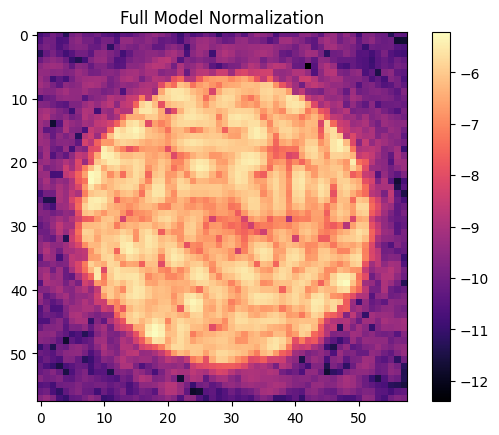

Core throughput within the half-max isophote(s) = 4.61% 	at separation = (-7.0, 0.0) lambda0/D.
Computing control Jacobian matrices in parallel...done.
Elapsed: 32.9865825176239
[Getting updated summed image]	Elapsed: 15.701528310775757


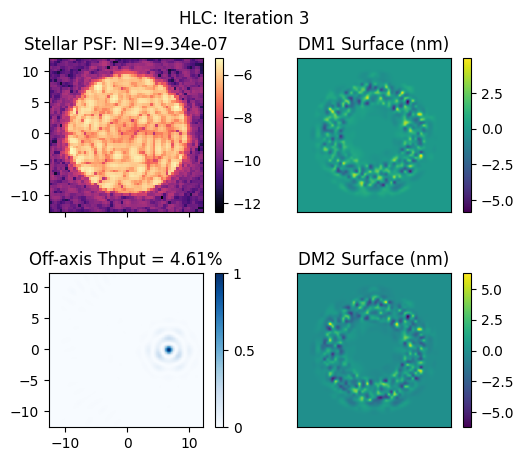

Complex projection of deltaE is 1.04    for subband 0/0
Complex correlation of deltaE is 0.97    for subband 0/0
Using the Jacobian to make other matrices...done.
Control beginning ...
Scaling factor:		0.50		0.50		0.50		0.50		0.50		0.50		0.50		0.50		
log10reg:    		-6.0		-5.5		-5.0		-4.5		-4.0		-3.5		-3.0		-2.5		
Inorm:       		1.56e-06	1.01e-06	7.35e-07	6.04e-07	5.46e-07	5.12e-07	4.89e-07	4.71e-07	
Model-based grid search expects log10reg, = -2.5,	 dmfac = 0.50,	 4.71e-07 normalized intensity.
 DM1 P-V in volts: 11.294
 DM2 P-V in volts: 12.922
RMS surface of DM1 = 1.0 nm
RMS surface of DM2 = 1.1 nm
Previous Measured NI:			 9.34e-07 
Saving data snippet to:
	/home/kianmilani/Projects/falco-python/data/brief/hlc_575_test_snippet.pkl  ...done.

Iteration: 4 / 9
Zernike modes (Noll indexing) used in this Jacobian:	[1]
DMs to be used in this iteration = [ 1 2 ]


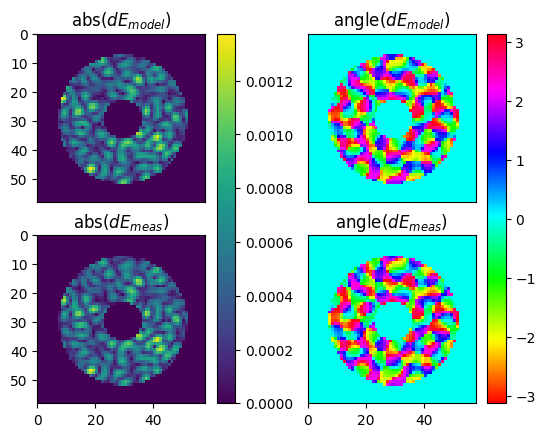

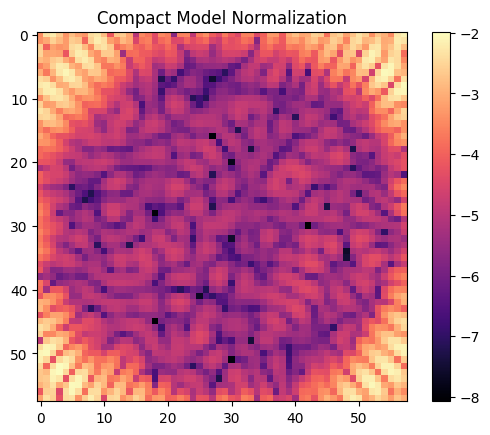

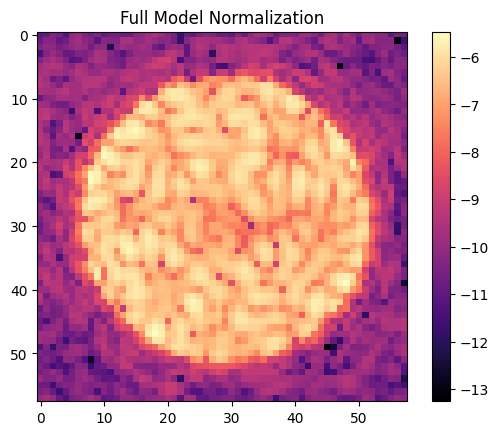

Core throughput within the half-max isophote(s) = 4.61% 	at separation = (-7.0, 0.0) lambda0/D.
Computing control Jacobian matrices in parallel...done.
Elapsed: 44.76633834838867
[Getting updated summed image]	Elapsed: 15.405023097991943


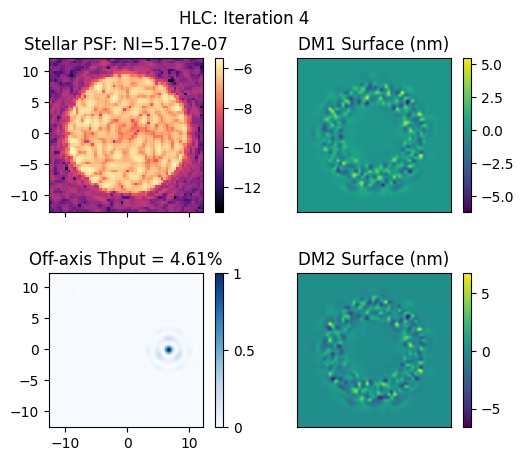

Complex projection of deltaE is 0.87    for subband 0/0
Complex correlation of deltaE is 0.94    for subband 0/0
Using the Jacobian to make other matrices...done.
Control beginning ...
Scaling factor:		0.50		0.50		0.50		0.50		0.50		0.50		0.50		0.50		
log10reg:    		-6.0		-5.5		-5.0		-4.5		-4.0		-3.5		-3.0		-2.5		
Inorm:       		9.14e-07	6.54e-07	4.81e-07	3.92e-07	3.49e-07	3.21e-07	3.01e-07	2.85e-07	
Model-based grid search expects log10reg, = -2.5,	 dmfac = 0.50,	 2.85e-07 normalized intensity.
 DM1 P-V in volts: 12.616
 DM2 P-V in volts: 13.405
RMS surface of DM1 = 1.1 nm
RMS surface of DM2 = 1.2 nm
Previous Measured NI:			 5.17e-07 
Saving data snippet to:
	/home/kianmilani/Projects/falco-python/data/brief/hlc_575_test_snippet.pkl  ...done.

Iteration: 5 / 9
Zernike modes (Noll indexing) used in this Jacobian:	[1]
DMs to be used in this iteration = [ 1 2 ]


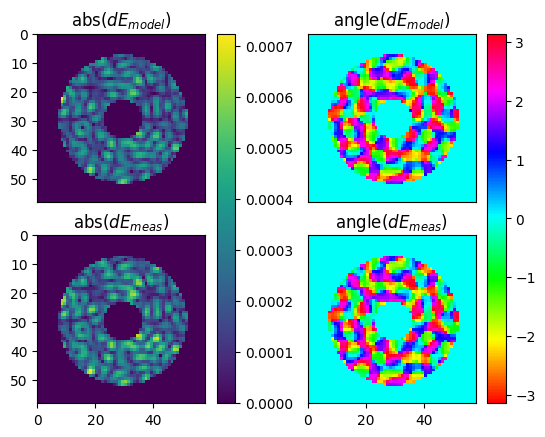

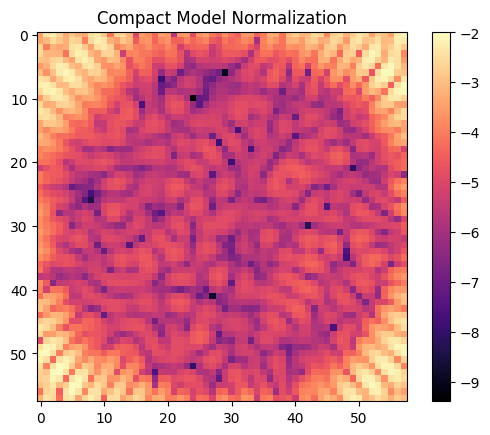

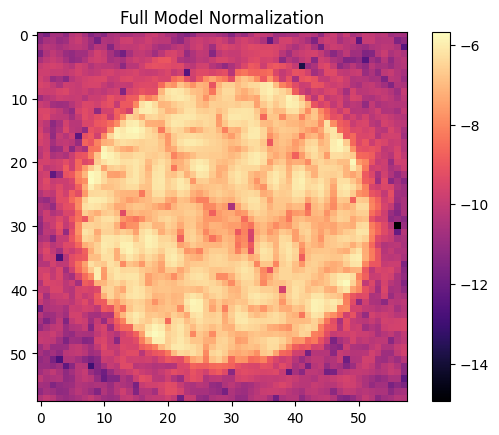

Core throughput within the half-max isophote(s) = 4.61% 	at separation = (-7.0, 0.0) lambda0/D.
Computing control Jacobian matrices in parallel...done.
Elapsed: 37.26341652870178
[Getting updated summed image]	Elapsed: 15.913883924484253


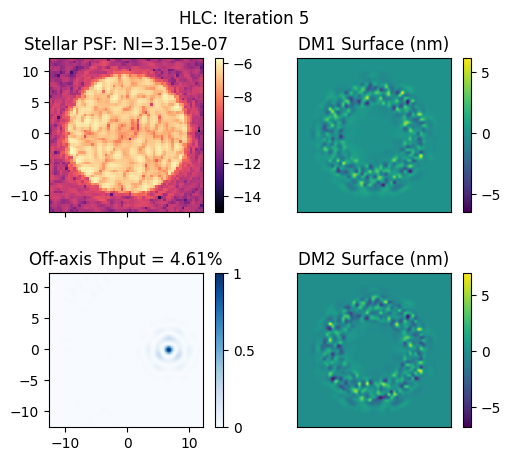

Complex projection of deltaE is 0.94    for subband 0/0
Complex correlation of deltaE is 1.00    for subband 0/0
Using the Jacobian to make other matrices...done.
Control beginning ...
Scaling factor:		0.50		0.50		0.50		0.50		0.50		0.50		0.50		0.50		
log10reg:    		-6.0		-5.5		-5.0		-4.5		-4.0		-3.5		-3.0		-2.5		
Inorm:       		6.16e-07	4.57e-07	3.43e-07	2.78e-07	2.44e-07	2.19e-07	2.01e-07	1.88e-07	
Model-based grid search expects log10reg, = -2.5,	 dmfac = 0.50,	 1.88e-07 normalized intensity.
 DM1 P-V in volts: 13.729
 DM2 P-V in volts: 13.788
RMS surface of DM1 = 1.1 nm
RMS surface of DM2 = 1.2 nm
Previous Measured NI:			 3.15e-07 
Saving data snippet to:
	/home/kianmilani/Projects/falco-python/data/brief/hlc_575_test_snippet.pkl  ...done.

Iteration: 6 / 9
Zernike modes (Noll indexing) used in this Jacobian:	[1]
DMs to be used in this iteration = [ 1 2 ]


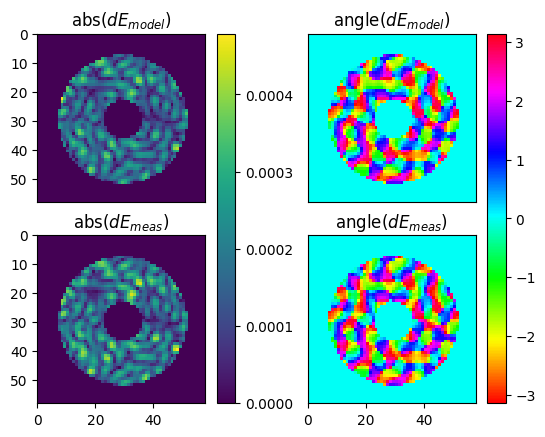

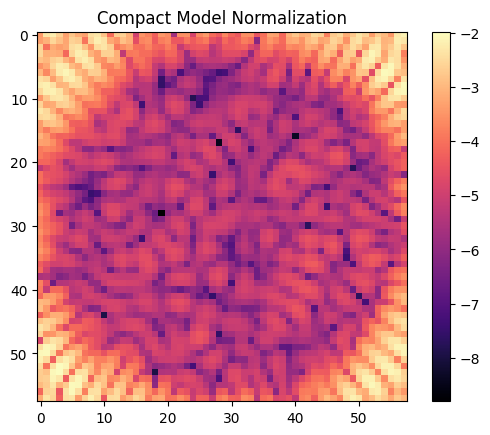

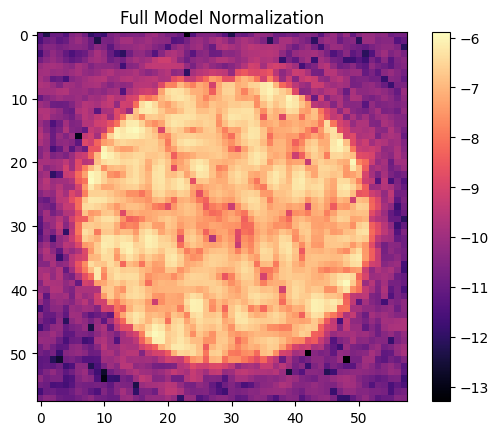

Core throughput within the half-max isophote(s) = 4.61% 	at separation = (-7.0, 0.0) lambda0/D.
Computing control Jacobian matrices in parallel...done.
Elapsed: 44.89260149002075
[Getting updated summed image]	Elapsed: 16.651024103164673


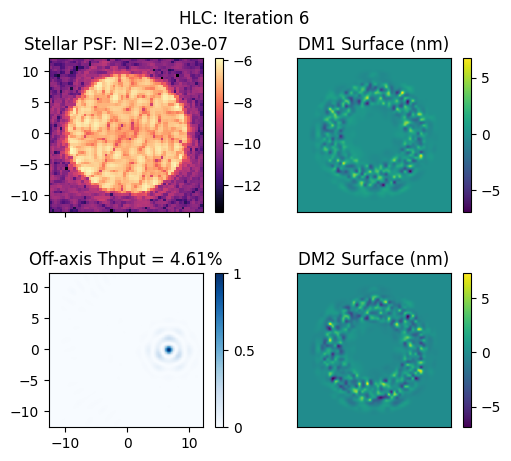

Complex projection of deltaE is 0.79    for subband 0/0
Complex correlation of deltaE is 0.99    for subband 0/0
Using the Jacobian to make other matrices...done.
Control beginning ...
Scaling factor:		0.50		0.50		0.50		0.50		0.50		0.50		0.50		0.50		
log10reg:    		-6.0		-5.5		-5.0		-4.5		-4.0		-3.5		-3.0		-2.5		
Inorm:       		4.43e-07	3.36e-07	2.54e-07	2.05e-07	1.77e-07	1.56e-07	1.40e-07	1.29e-07	
Model-based grid search expects log10reg, = -2.5,	 dmfac = 0.50,	 1.29e-07 normalized intensity.
 DM1 P-V in volts: 14.630
 DM2 P-V in volts: 14.320
RMS surface of DM1 = 1.1 nm
RMS surface of DM2 = 1.3 nm
Previous Measured NI:			 2.03e-07 
Saving data snippet to:
	/home/kianmilani/Projects/falco-python/data/brief/hlc_575_test_snippet.pkl  ...done.

Iteration: 7 / 9
Zernike modes (Noll indexing) used in this Jacobian:	[1]
DMs to be used in this iteration = [ 1 2 ]


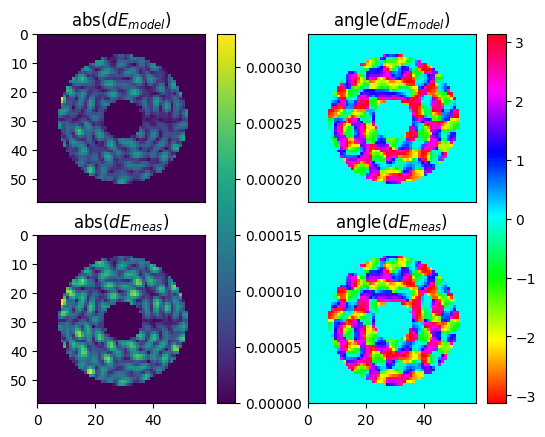

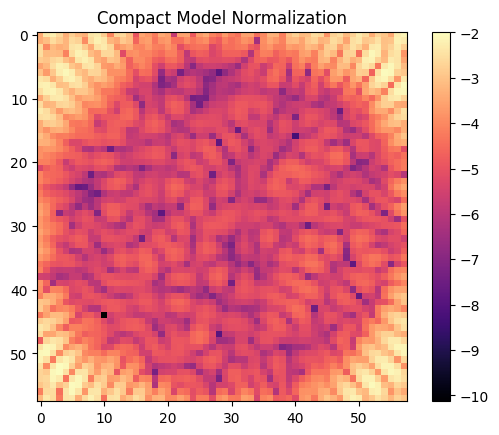

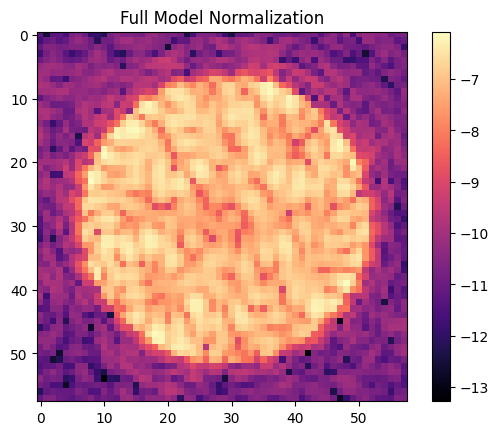

Core throughput within the half-max isophote(s) = 4.61% 	at separation = (-7.0, 0.0) lambda0/D.
Computing control Jacobian matrices in parallel...done.
Elapsed: 42.68781661987305


In [ ]:
# Record Keeping
mp.TrialNum = 1
mp.SeriesNum = 1

mp.runLabel = ('hlc_575_test')
print(mp.runLabel)


# %% Perform the Wavefront Sensing and Control

out = falco.setup.flesh_out_workspace(mp)
falco.wfsc.loop(mp, out)


In [ ]:
misc.save_pickle(mp.runLabel + '_mp.pkl', mp)
misc.save_pickle(mp.runLabel + '_out.pkl', out)

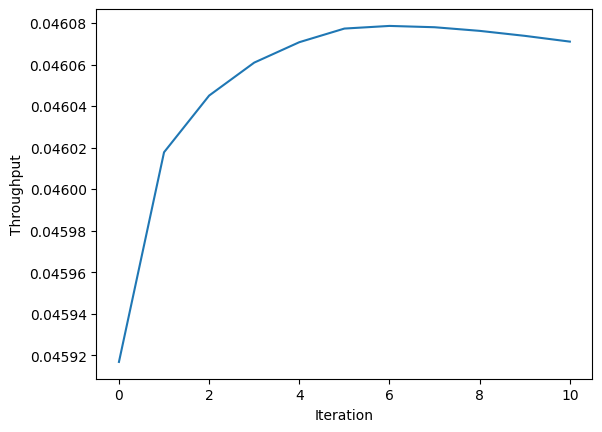

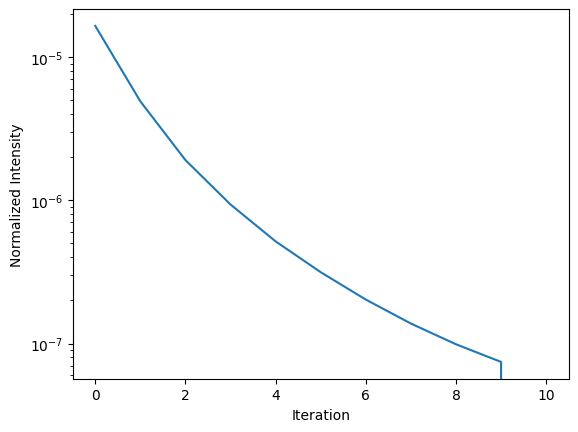

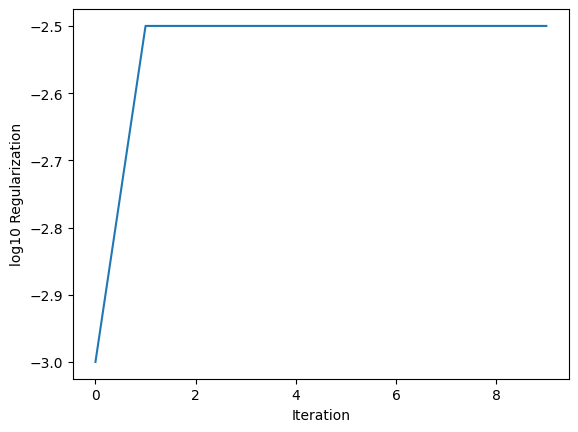

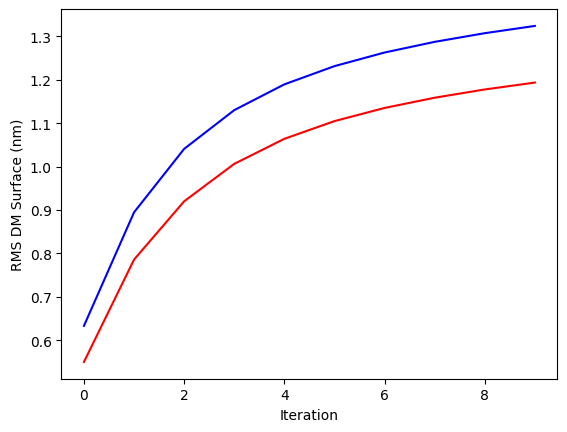

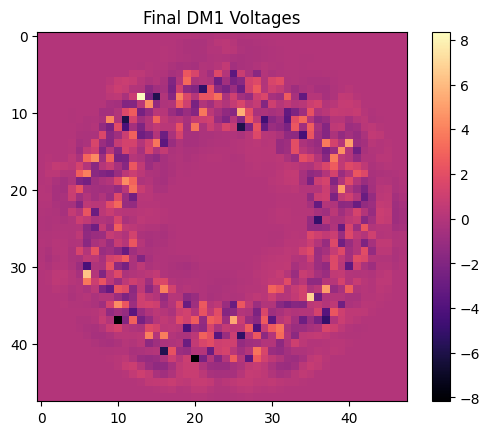

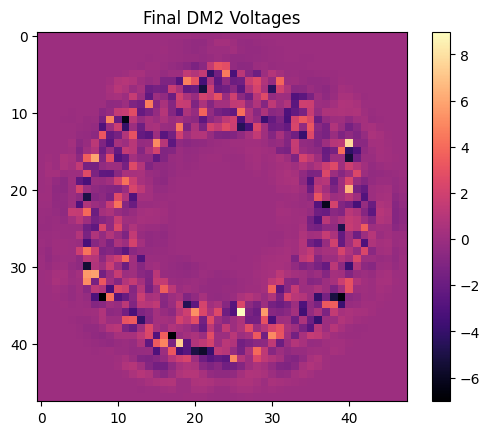

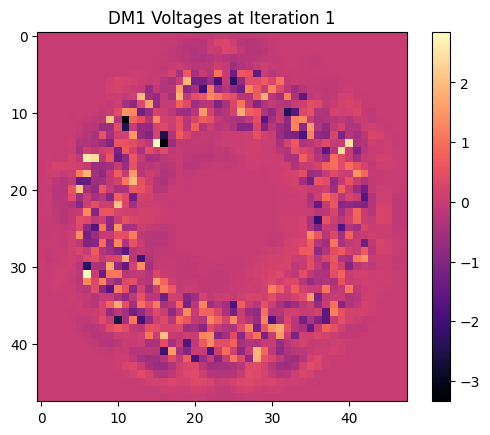

In [19]:
# %% Plot the output
falco.plot.plot_trial_output(out)